In [1]:
import analysis
import importlib
importlib.reload(analysis)

import numpy as np
import matplotlib.pyplot as plt
import corner
import symbolic_pofk.syrenhalofit as syrenhalofit
import borg_velocity.utils
import aquila_borg as borg
import Pk_library as PKL

Initializing console.
[0 / 1] [INFO   ] libLSS version 6b1404bfd8011f03ee1b8635275f68d14d16bef3 built-in modules 
[0 / 1] [STD    ] Using OneAPI/TBB (default scheduler).
[0 / 1] [INFO S ] Registered likelihoods:
[0 / 1] [INFO S ]    BORG_NULL, BORG_POISSON, BORG_REDUCED_SHEAR, BORG_SHEAR, BORG_STUDENT_T
[0 / 1] [INFO S ]    EFT_BIAS_LIKE, EFT_BIAS_MARG_LIKE, GAUSSIAN_BROKEN_POWER_LAW_BIAS, GAUSSIAN_LINEAR_BIAS
[0 / 1] [INFO S ]    GAUSSIAN_LINEAR_BIAS_DEGRADE2, GAUSSIAN_LINEAR_BIAS_DEGRADE4, GAUSSIAN_LINEAR_BIAS_DEGRADE8
[0 / 1] [INFO S ]    GAUSSIAN_MO_WHITE_BIAS, GAUSSIAN_POWER_LAW_BIAS, GENERIC_GAUSSIAN_MANY_POWER_1^1
[0 / 1] [INFO S ]    GENERIC_GAUSSIAN_MANY_POWER_1^2, GENERIC_POISSON_BROKEN_POWERLAW_BIAS
[0 / 1] [INFO S ]    GENERIC_POISSON_BROKEN_POWERLAW_BIAS_DEGRADE2, GENERIC_POISSON_BROKEN_POWERLAW_SIGMOID_BIAS
[0 / 1] [INFO S ]    GENERIC_POISSON_MANY_POWER_1^1, GENERIC_POISSON_MANY_POWER_1^2, GENERIC_POISSON_MANY_POWER_1^2_DEGRADE2
[0 / 1] [INFO S ]    GENERIC_POISSON_MANY_

2025-01-31 09:00:11.933354: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.0 which is older than the PTX compiler version (12.6.77). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Density Field Slice

Computing ensemble mean field


100%|██████████| 239/239 [00:15<00:00, 15.61it/s]


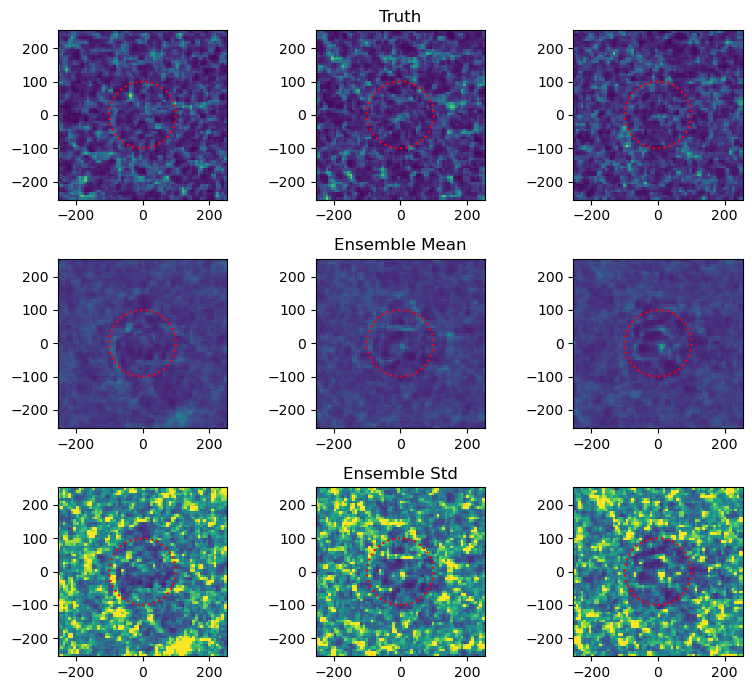

In [2]:
borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics'
iter_min = 1000
iter_max = 5526

borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model'
iter_min = 1000
iter_max = 8162

borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model_cosmo'
iter_min = 1000
iter_max = 2626

borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model_cola_v3'
iter_min = 0
iter_max = -1

ini_name = borg_dirname + '/ini_file.ini'
field_type = 'delta'
nframe = 200
cut_field = True
cut_field = False

true_delta = analysis.crop_velmass_to_borg(ini_name, field_type)
if cut_field:
    true_delta, _ = analysis.crop_field(ini_name, true_delta)
borg_mean, borg_std = analysis.compute_ensemble_mean_field(ini_name, borg_dirname, nframe, iter_max, iter_min, cut_field=cut_field)

fig, axs = plt.subplots(3, 3, figsize=(8,7))

# Parameter for uncut box
Rmax = analysis.get_borg_Rmax(ini_name)
L0 = analysis.get_borg_Lbox(ini_name)
N0 = analysis.get_borg_N(ini_name)
corner0 = analysis.get_borg_corner(ini_name)

x = np.linspace(corner0, corner0+L0, N0)
if cut_field:
    m = np.abs(x) < Rmax
    x = x[m]

for i, field in enumerate([np.log10(2+true_delta), np.log10(2+borg_mean), borg_std]):
    if i == 0:
        vmin = field.min()
        vmax = field.max()
    N = field.shape[0]
    j = N//2
    axs[i,0].pcolor(x, x, field[j], vmin=vmin, vmax=vmax)
    axs[i,1].pcolor(x, x, field[:,j,:], vmin=vmin, vmax=vmax)
    axs[i,2].pcolor(x, x, field[:,:,j], vmin=vmin, vmax=vmax)
    for ax in axs[i,:]:
        circle = plt.Circle((0, 0), Rmax, color='red', fill=False, linestyle='dotted', lw=1.5)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.add_patch(circle)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    for ax in axs[i,:]:
        ax.set_aspect('equal')

axs[0,1].set_title('Truth')
axs[1,1].set_title('Ensemble Mean')
axs[2,1].set_title('Ensemble Std')

fig.tight_layout()

savename = f'../figs/field_slice_velmass_{field_type}'
if cut_field:
    savename += '_cropped'
fig.savefig(f'{savename}.png', bbox_inches='tight', facecolor='white')

# Power and Cross Spectra

BOXSIZE 198.41269841269843

Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.03 seconds


100%|██████████| 110/110 [00:06<00:00, 15.96it/s]


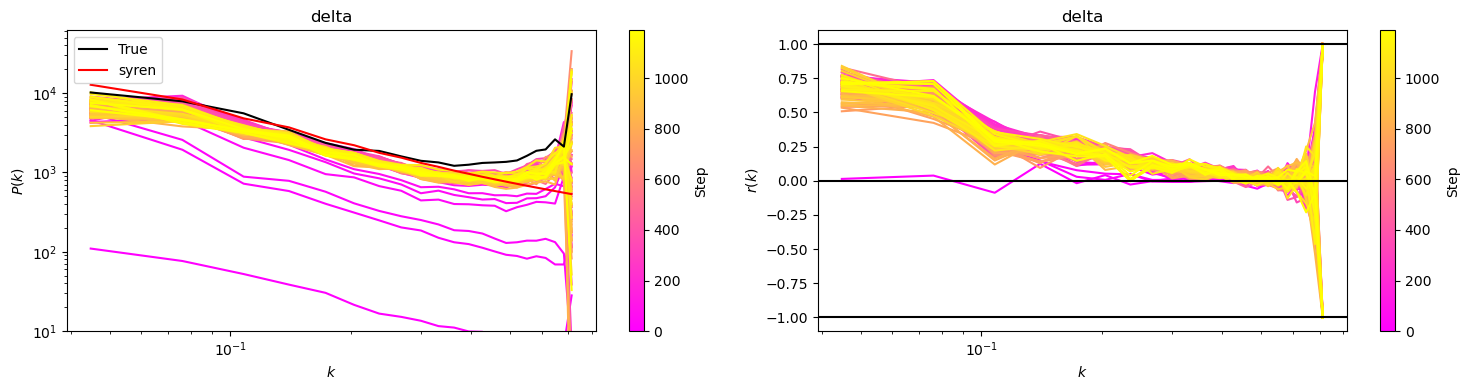

In [3]:
borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics'
iter_min = 0
iter_max = 5526

borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model'
iter_min = 0
iter_max = 8162

# borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model_cosmo'
# iter_min = 1000
# iter_max = 2626

borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model_cola_v3'
iter_min = 0
iter_max = -1

ini_name = borg_dirname + '/ini_file.ini'
field_type = 'delta'
# field_type = 'ics'
nframe = 100
cut_field = True
# cut_field = False

k, Pk_true, all_pk, all_r = analysis.get_spectra(ini_name, borg_dirname, nframe, iter_max, iter_min, which_field=field_type, cut_field=cut_field, mock_type='velmass', MAS='')
all_mcmc = analysis.get_mcmc_steps(borg_dirname, nframe, iter_max, iter_min=iter_min)

cpar = borg_velocity.utils.get_cosmopar(ini_name)
pk_syrenhalofit = syrenhalofit.run_halofit(k, 
                       cpar.sigma8, cpar.omega_m, cpar.omega_b, cpar.h, cpar.n_s, 1.0,
                       emulator='fiducial', extrapolate=True, which_params='Bartlett', add_correction=True)

# Get axis range
if field_type == 'delta':
    ymin = 1e1
    ymax = None
else:
    ymin = None
    ymax = None

# Normalize the index for coloring
norm = plt.Normalize(all_mcmc[0], all_mcmc[-1])
cmap = plt.cm.spring  # Choose a colormap

fig, axs = plt.subplots(1, 2, figsize=(15,4))

# Plot Pk and r
for i in range(all_pk.shape[0]):
    axs[0].loglog(k, all_pk[i, :], color=cmap(norm(all_mcmc[i])))
    axs[1].semilogx(k, all_r[i, :], color=cmap(norm(all_mcmc[i])))
axs[0].loglog(k, Pk_true, color='k', label='True')
axs[0].loglog(k, pk_syrenhalofit, color='r', label='syren')
for i in [-1, 0, 1]:
    axs[1].axhline(i, color='k')
axs[0].legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
for ax in axs:
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Step')
    ax.set_title(field_type)
    ax.set_xlabel(r'$k$')
axs[0].set_ylim(ymin, ymax)
axs[0].set_ylabel(r'$P(k)$')
axs[1].set_ylabel(r'$r(k)$')
fig.tight_layout()
savename = f'../figs/pk_velmass_{field_type}'
if cut_field:
    savename += '_cropped'
fig.savefig(f'{savename}.png', bbox_inches='tight', facecolor='white')

# Model Parameters

TO SAMPLE ['mua', 'alpha', 'lam', 'sig_v', 'bulk_flow']
MY SAMPLER IS transformedblackjax
['mua0', 'mua1', 'mua2', 'mua3', 'alpha0', 'alpha1', 'alpha2', 'alpha3', 'lam0', 'lam1', 'lam2', 'lam3', 'sig_v', 'bulk_flow_x', 'bulk_flow_y', 'bulk_flow_z']


100%|██████████| 1190/1190 [00:01<00:00, 877.13it/s]


['mua0', 'mua1', 'mua2', 'mua3', 'alpha0', 'alpha1', 'alpha2', 'alpha3', 'lam0', 'lam1', 'lam2', 'lam3', 'sig_v', 'bulk_flow_x', 'bulk_flow_y', 'bulk_flow_z']
(16, 1190)


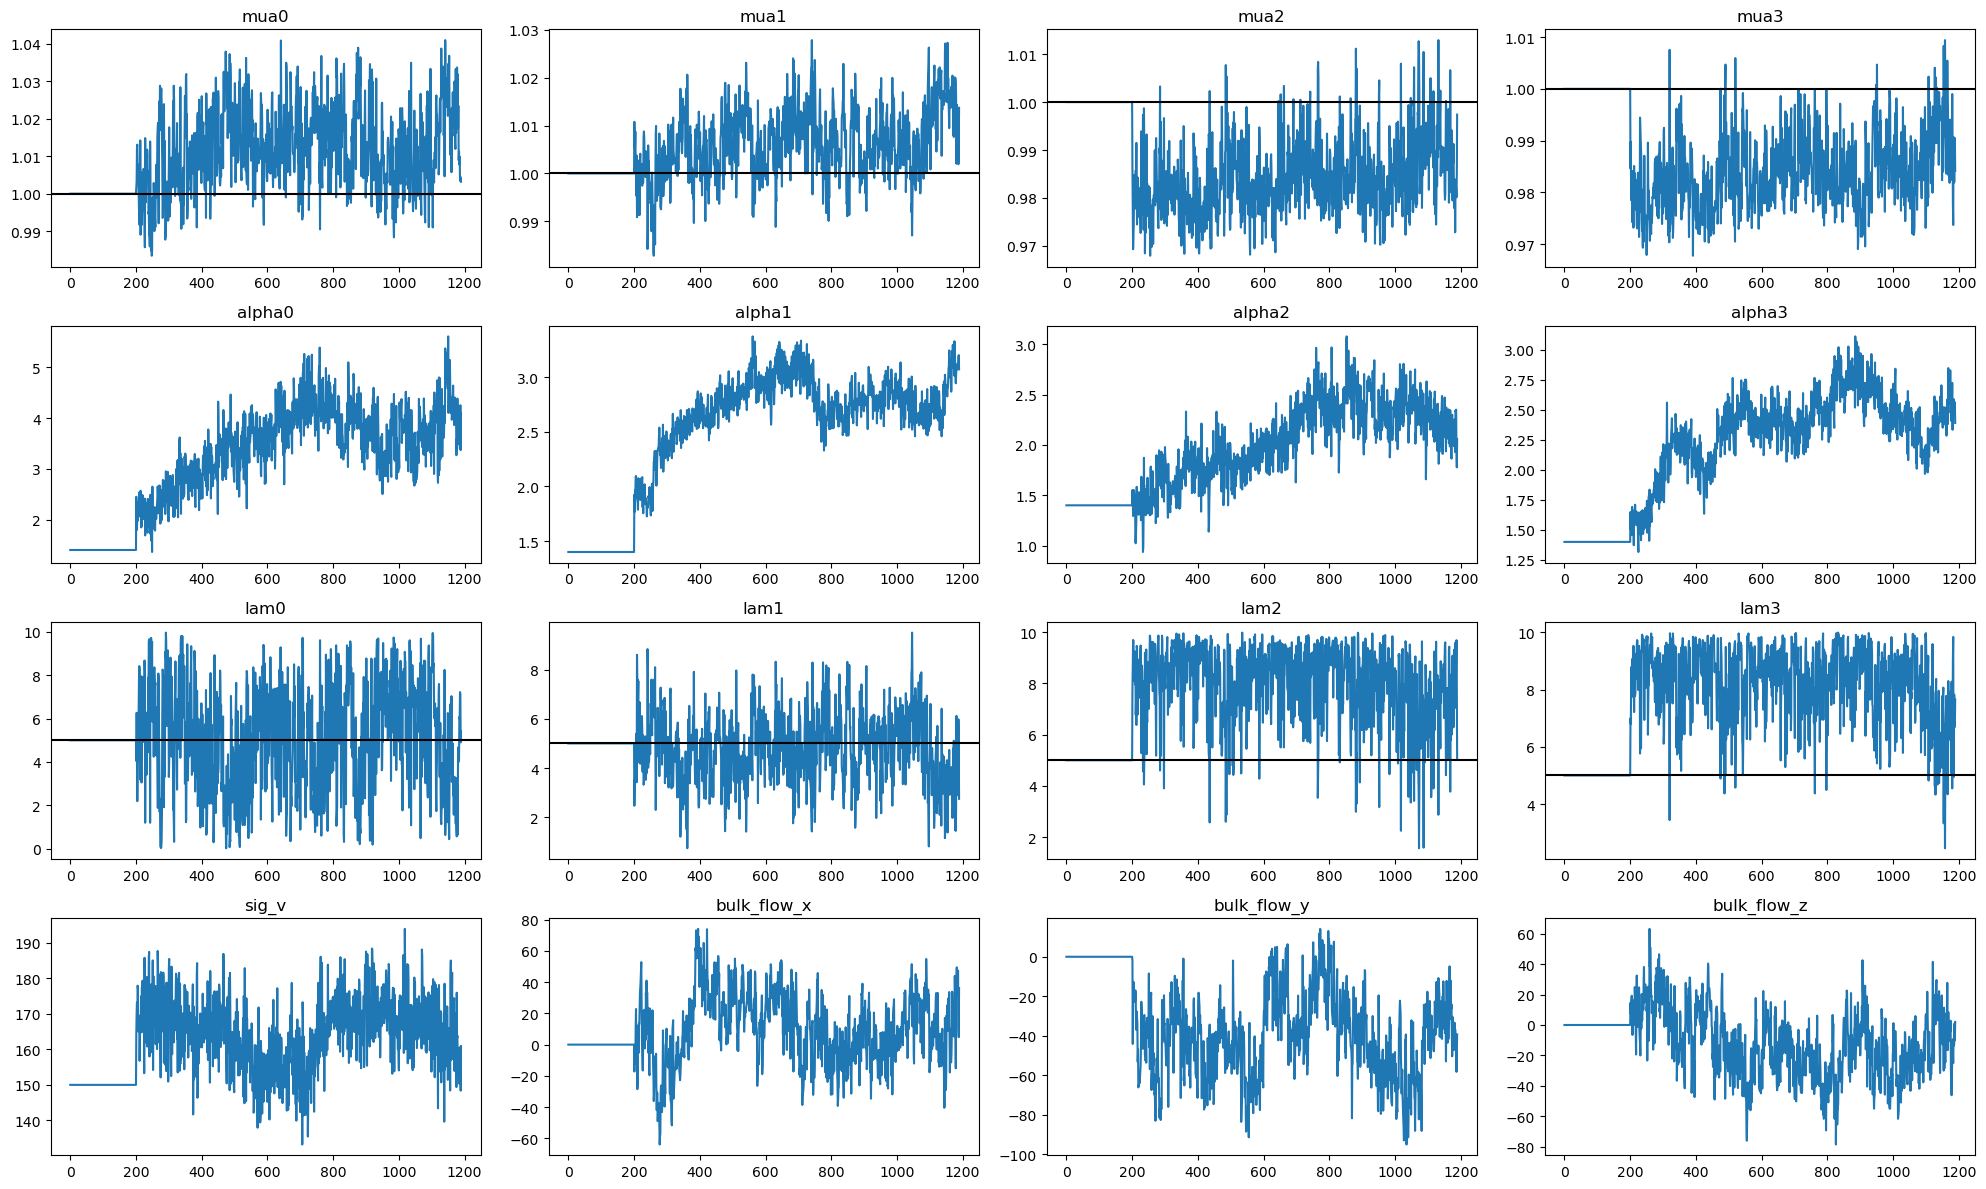

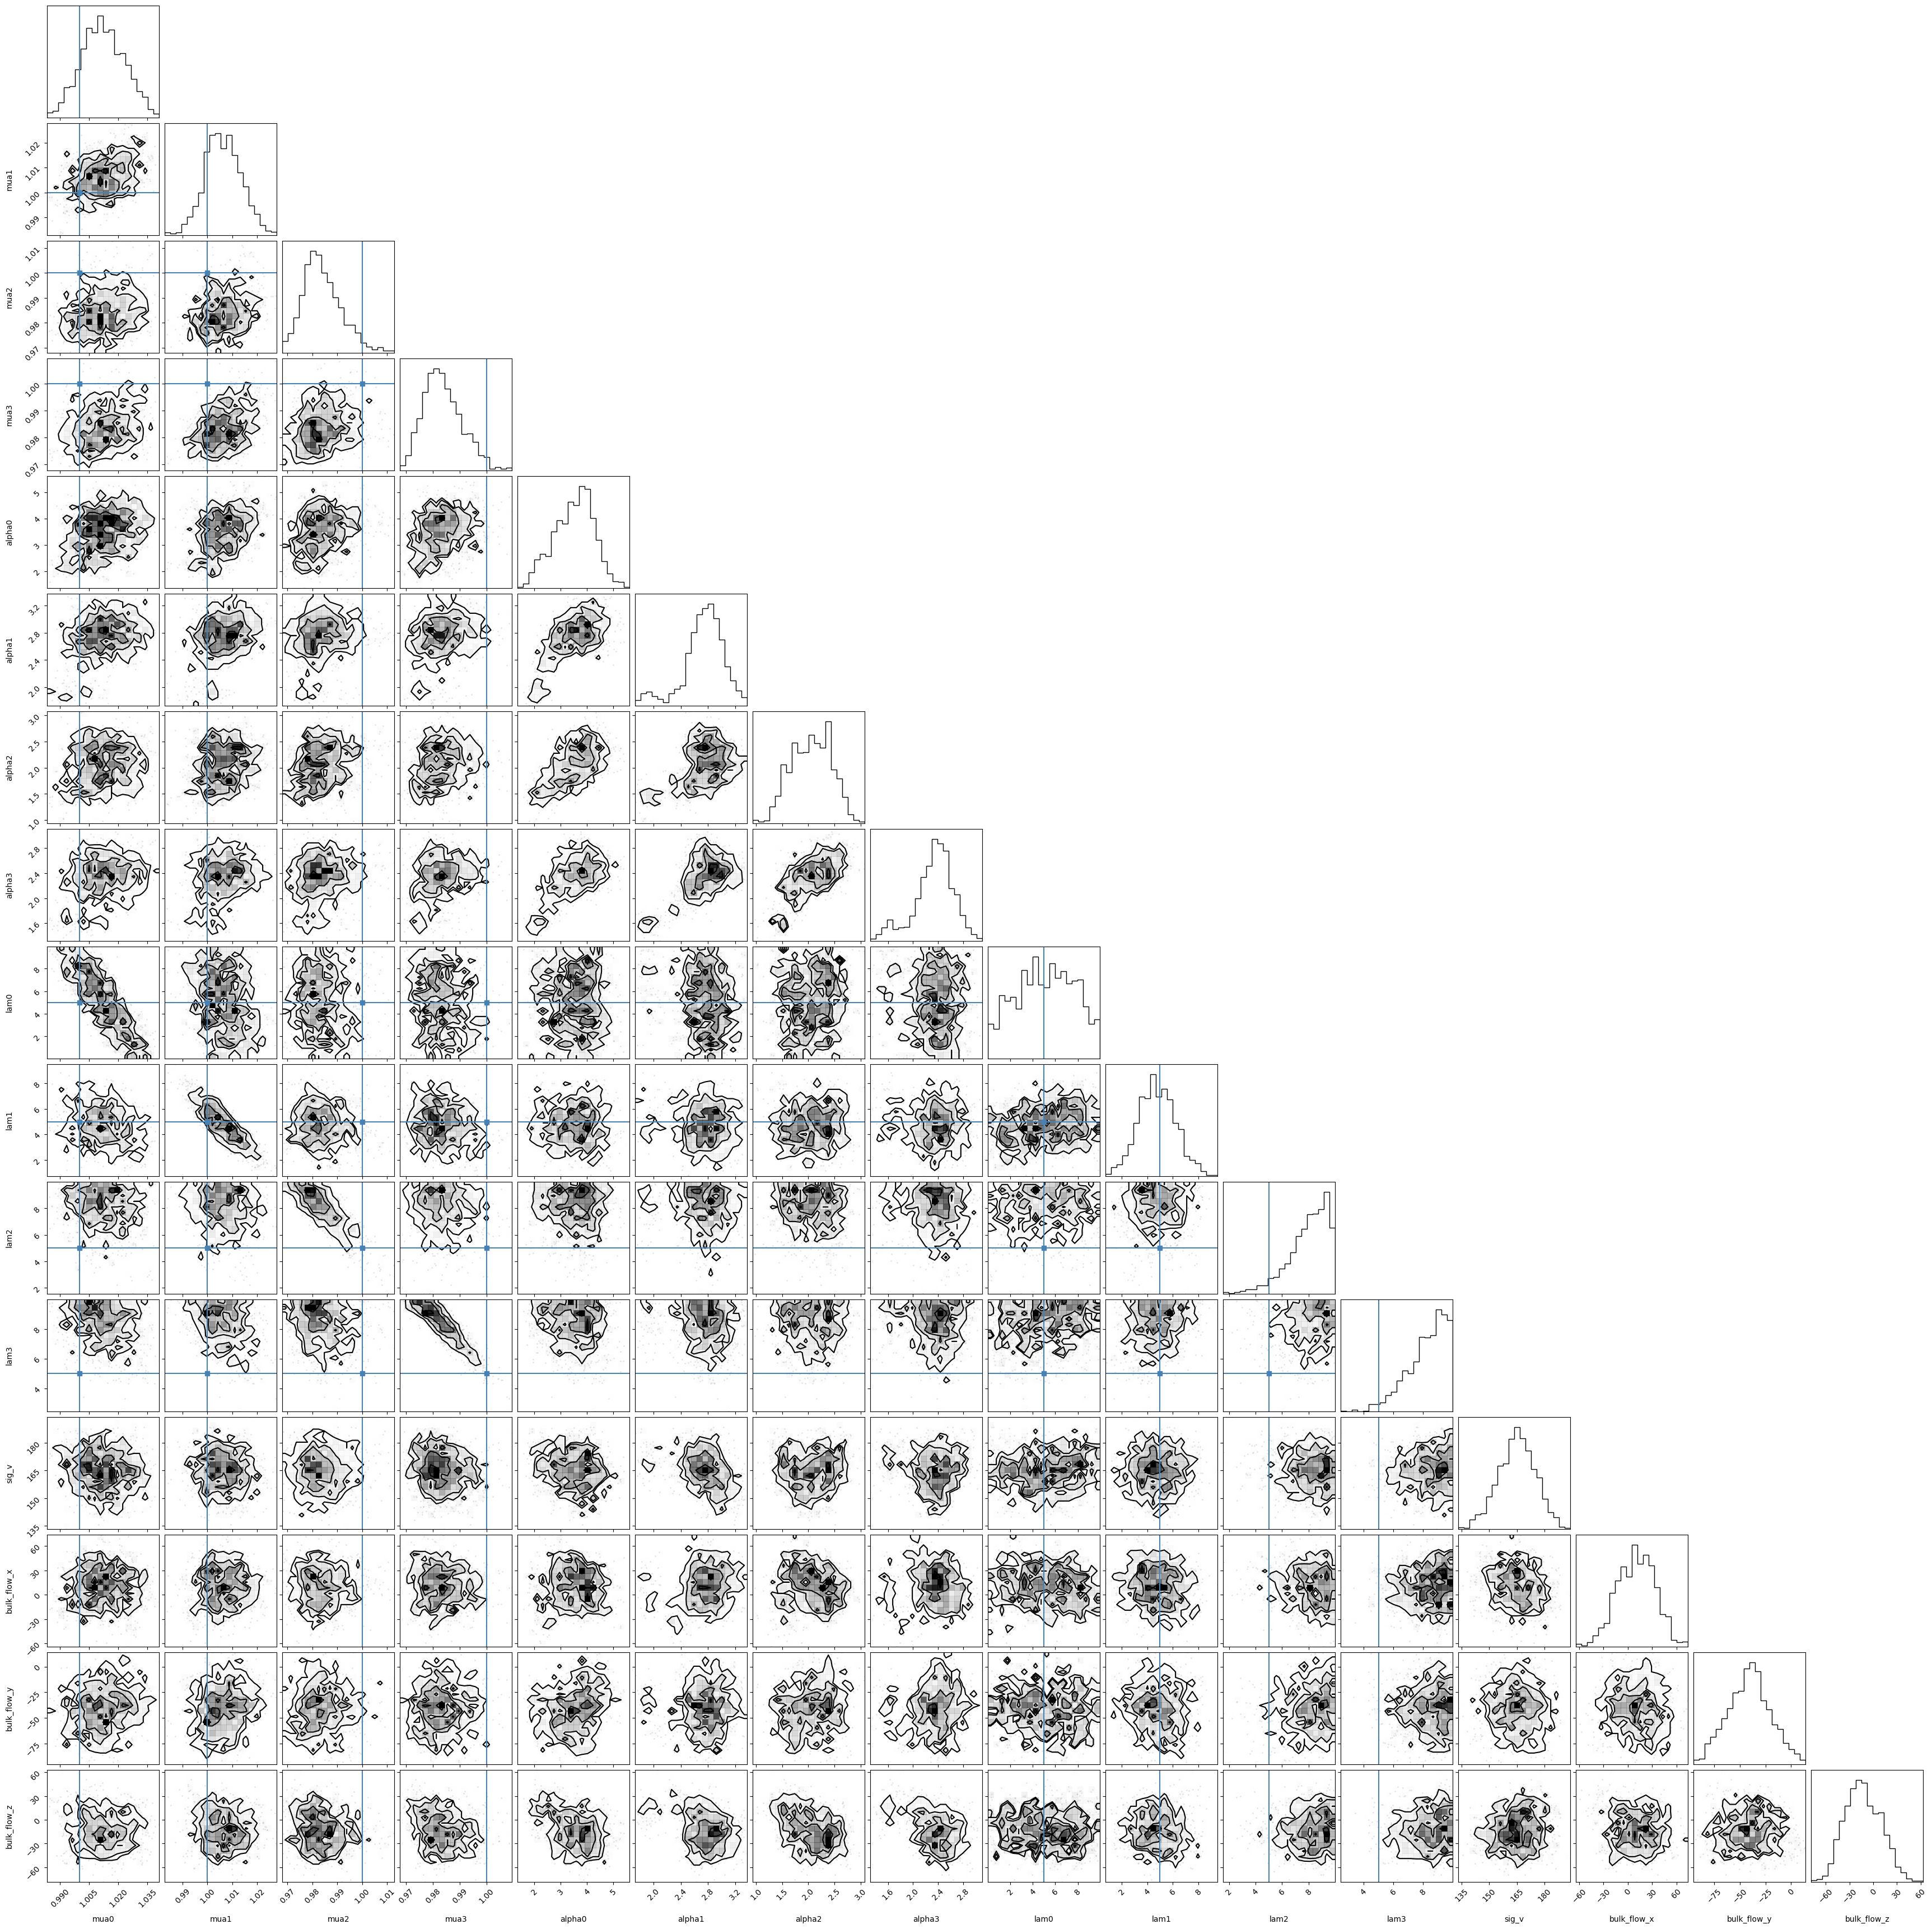

In [9]:
borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model'
iter_min = 0
iter_max = 8162

borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model_cosmo'
iter_min = 0
iter_max = 2626

borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model_cola_v3'
iter_min = 0
iter_max = -1

nframe = 2000
# burn_in = 1000
burn_in = 200

ini_name = borg_dirname + '/ini_file.ini'
param_names, all_mcmc, samples = analysis.load_param_samples(ini_name, borg_dirname, nframe, iter_max, iter_min)
truths = analysis.get_truths(ini_name, param_names)

print(param_names)
print(samples.shape)

# For Velmass some of these are not in fact truths
for i, p in enumerate(param_names):
    if p.startswith('alpha') or p.startswith('sig_v') or p.startswith('bulk_flow'):
        truths[i] = None

# print(param_names)
# print(samples.shape)
# for i, n in enumerate(param_names):
#     if n.startswith('lam'):
#         truths[i] = 1 / truths[i]
#         samples[i,:] = 1 / samples[i,:]
#         m = samples[i,:] < 1
#         samples = samples[:,m]
#         all_mcmc = all_mcmc[m]

ncol = 4
nrow = int(np.ceil(samples.shape[0] / ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 5, nrow * 3))
axs = axs.flatten()
for i in range(len(samples)):
    ax = axs[i]
    ax.plot(all_mcmc, samples[i])
    ax.set_title(param_names[i])
    if truths[i] is not None:
        ax.axhline(truths[i], color='k')
for i in range(len(samples), len(axs)):
    axs[i].clear()
    axs[i].remove()
fig.tight_layout()
fig.savefig('../figs/trace_velmass.png', bbox_inches='tight', facecolor='white')

m = all_mcmc > burn_in

# Full corner plot
corner.corner(
    samples[:,m].T,
    labels=param_names,
    truths=truths
)
fig = plt.gcf()
fig.savefig('../figs/corner_velmass.png', bbox_inches='tight', facecolor='white')

# Check VELMASS Power Spectrum against Emulator

<CosmologicalParameters: omega_r=0, omega_k=0, omega_m=0.315, omega_b=0.049, omega_q=0.685, w=-1, n_s=0.97, fnl=0, wprime=0, sigma8=0.81, h=0.68, sum_mnu=0 eV, As=1.96592e-09>
2000.0 500.0 500.0 96 160 256
-0.9290850623568685 28.859140827923998 9.489479514679378e-17
Lbox: 500.0

Computing power spectrum of the field...
Time to complete loop = 0.01
Time taken = 0.01 seconds


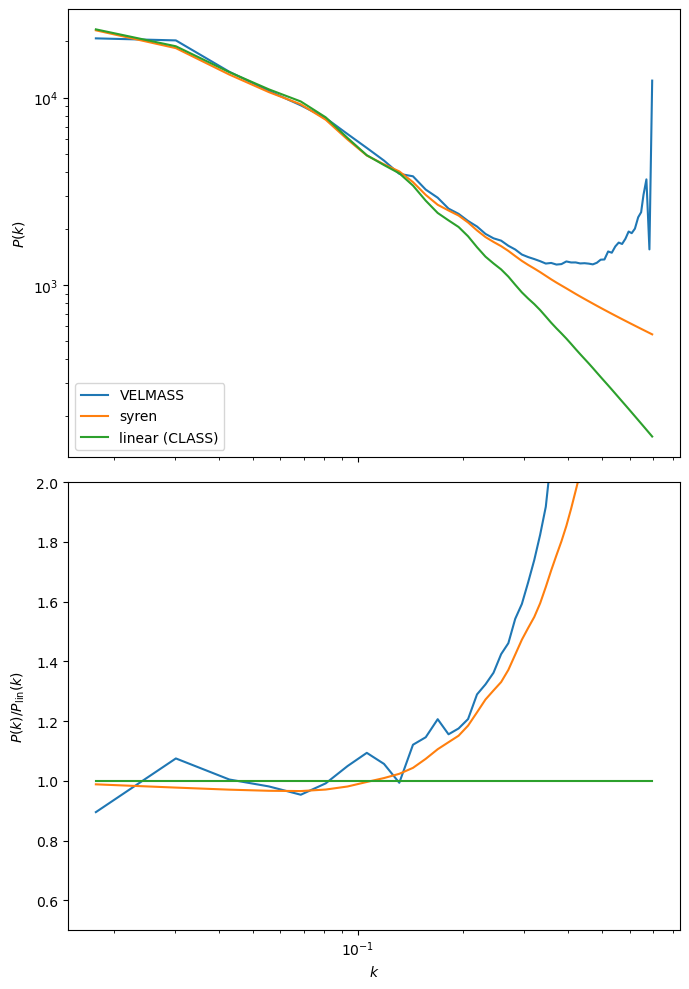

In [52]:
borg_dirname = '/data101/bartlett/fsigma8/borg_velocity/velmass_ics_model'
ini_name = borg_dirname + '/ini_file.ini'

cpar = borg_velocity.utils.get_cosmopar(ini_name)
print(cpar)

# k, Pk_true, _, _ = analysis.get_spectra(ini_name, borg_dirname, 1., -1, 0, which_field='delta', cut_field=False, mock_type='velmass')
delta1 = analysis.get_velmass_field(ini_name, 'delta')
boxsize = analysis.get_velmass_Lbox(ini_name)

Lbox_true = analysis.get_velmass_Lbox(ini_name)
Lbox_borg = analysis.get_borg_Lbox(ini_name)
N = delta1.shape[0]
imin = int((1 - Lbox_borg / Lbox_true) * N / 2)
imax = int((1 + Lbox_borg / Lbox_true) * N / 2)
Lbox_new = (imax - imin) / N * Lbox_true
print(Lbox_true, Lbox_borg, Lbox_new, imin, imax, N)
boxsize = Lbox_new
delta1 = delta1[imin:imax, imin:imax, imin:imax]
# delta1 = delta1[:imax-imin, :imax-imin, :imax-imin]
delta1 = (1 + delta1) / (1 + delta1).mean() - 1.
print(delta1.min(), delta1.max(), delta1.mean())

print("Lbox:", boxsize)
MAS = "CIC"
Pk = PKL.Pk(delta1.astype(np.float32), boxsize, axis=0, MAS=MAS, threads=1, verbose=True)
k      = Pk.k3D
Pk_true     = Pk.Pk[:,0]



k_max, k_per_decade = 10, 100
extra_class = {}
extra_class['YHe'] = '0.2458'
cosmo = borg.cosmo.ClassCosmo(cpar, k_per_decade, k_max, extra=extra_class)

# Compute integrand
plin_class = cosmo.get_Pk_matter(k)

pk_syrenhalofit = syrenhalofit.run_halofit(k, 
                       cpar.sigma8, cpar.omega_m, cpar.omega_b, cpar.h, cpar.n_s, 1.0,
                       emulator='fiducial', extrapolate=True, which_params='Bartlett', add_correction=True)

fig, axs = plt.subplots(2, 1, figsize=(7,10), sharex=True)
axs[0].loglog(k, Pk_true, label='VELMASS')
axs[0].loglog(k, pk_syrenhalofit, label='syren')
axs[0].loglog(k, plin_class, label='linear (CLASS)')
axs[1].semilogx(k, Pk_true / plin_class, label='VELMASS')
axs[1].semilogx(k, pk_syrenhalofit / plin_class, label='syren')
axs[1].semilogx(k, plin_class / plin_class, label='linear (CLASS)')
axs[0].legend()
axs[0].set_ylabel(r'$P(k)$')
axs[1].set_ylabel(r'$P(k) / P_{\rm lin}(k)$')
axs[1].set_xlabel(r'$k$')
axs[1].set_ylim(0.5, 2)
fig.align_labels()
fig.tight_layout()

# TO DO

* Looks like VELMASS ICs are after P(k) applied - extract white noise field